## ResNet 50

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import shutil
import os
from PIL import Image
from tempfile import TemporaryDirectory

torch.manual_seed(0)
plt.ion()
##udnn.benchmark = True

Divido i dati del dataset nel seguente modo in cartelle:
- only_pieces/
    - test/
        - w_Pawn/
        - ...
    - train/
        - w_Pawn/
        - ...
    - val/
        - w_Pawn/
        - ...

In [2]:
dataset_path = './../output/only_pieces/'
class_names = ["w_Pawn", "w_Knight", "w_Bishop", "w_Rook", "w_Queen", "w_King",
                   "b_Pawn", "b_Knight", "b_Bishop", "b_Rook", "b_Queen", "b_King"]
data = []
labels = []
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        data.append(img_path)
        labels.append(class_name)

data, labels = shuffle(data, labels, random_state=42)
# Split the data into training and temporary sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the temporary set into validation and test sets
test_data, validation_data, test_labels, validation_labels = train_test_split(temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
data_set = {'train':[train_data, train_labels], 'test': [test_data, test_labels], 'val':[validation_data, validation_labels]}

In [3]:
classes_c = ["w_Pawn", "w_Knight", "w_Bishop", "w_Rook", "w_Queen", "w_King",
                   "b_Pawn", "b_Knight", "b_Bishop", "b_Rook", "b_Queen", "b_King"]

directory = ["test", "train", "val"]
if not os.path.exists(f'./../output/only_pieces/resnet'):
        os.mkdir(f'./../output/only_pieces/resnet')

for d in directory:
      if not os.path.exists(f'./../output/only_pieces/resnet/{d}'):
        os.mkdir(f'./../output/only_pieces/resnet/{d}')
        for c in classes_c:
            if not os.path.exists(f'./../output/only_pieces/resnet/{d}/{c}'):
                os.mkdir(f'./../output/only_pieces/resnet/{d}/{c}')



In [4]:

for k, v in data_set.items():
    for i in range(len(v[0])):
        base_name= os.path.basename(v[0][i])
        path = os.listdir(f"./../output/only_pieces/resnet/{k}/{v[1][i]}")
        if base_name not in path:
            shutil.copy(v[0][i], f"./../output/only_pieces/resnet/{k}/{v[1][i]}")
            

Transformazioni dati di input (preso da https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        ##TODO: ASSOLUTAMENTE DA CAPIRE SE POSSIAMO TOGLIERLO NELLA NOSTRA IMPLEMENTAZIONE PERCHE' SE NO CI TAGLIA IL PEZZO!!
        #transforms.RandomResizedCrop(224),
        transforms.CenterCrop(190),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(190),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        ##TODO: ASSOLUTAMENTE DA CAPIRE SE POSSIAMO TOGLIERLO NELLA NOSTRA IMPLEMENTAZIONE PERCHE' SE NO CI TAGLIA IL PEZZO!!
        #transforms.RandomResizedCrop(224),
        transforms.CenterCrop(190),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Load data 

In [6]:
data_dir = './../output/only_pieces/resnet'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Esempio visivo di come croppa la trasformazione i sample

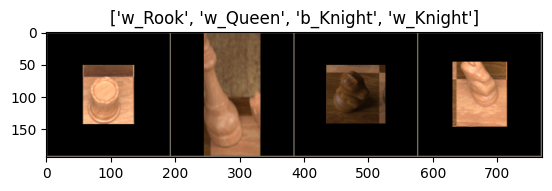

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Dichiarazione della funzione per il training del modello

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Funzione che permette di vedere visualmente se il modello ha classificato correttamente

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(classes_c))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Mostra una rappresentazione tabulare del modello
summary(model_ft, input_size=(3, 190, 190))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Training

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 2.1050 Acc: 0.3125
val Loss: 1.4626 Acc: 0.5714

Epoch 1/4
----------
train Loss: 1.6001 Acc: 0.4948
val Loss: 1.0218 Acc: 0.7143

Epoch 2/4
----------
train Loss: 1.2141 Acc: 0.5990
val Loss: 0.8051 Acc: 0.7381

Epoch 3/4
----------
train Loss: 0.8802 Acc: 0.7031
val Loss: 0.5403 Acc: 0.7857

Epoch 4/4
----------
train Loss: 0.5565 Acc: 0.8125
val Loss: 0.5355 Acc: 0.8095

Training complete in 2m 51s
Best val Acc: 0.809524


Inferenza

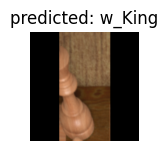

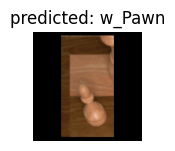

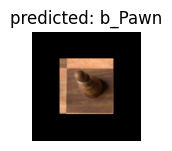

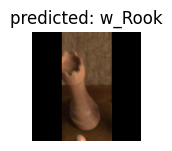

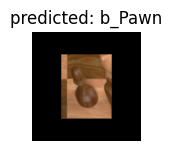

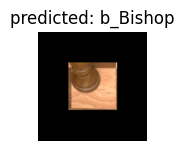

In [12]:
visualize_model(model_ft)